## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 1: Let's GOOOOO!

- **100 points [7% of your final grade]**
- **Due Tuesday, February 13 by 11:59pm**

***Goals of this homework:***
1. Collect data from the web, clean it, and then make some observations based on exploratory data analysis
2. Understand and implement the classic apriori algorithm and extensions to find the association rules in a movie rating dataset

***Submission instructions:***

You should post your notebook to Canvas (look for the homework 1 assignment there). Please name your submission **your-uin_hw1.ipynb**, so for example, my submission would be something like **555001234_hw1.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. 

***Late Days:***

As a reminder, you may use up to three of your late days on this homework, meaning the latest we will accept it is February 16 by 11:59pm.

***Collaboration declaration:***

If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

## (50 points) Part 1: UFOs

### (10pts) Part 1a: UFOs are Out There, But First I Need to Store them Locally

For this first part, we're going to collect evidence of UFO sightings from the **National UFO Reporting Center**. Specifically, we're going 
to focus only on UFO sightings in Texas, as reported at this webpage:

* http://www.nuforc.org/webreports/ndxlTX.html

Recall that you can view the source of a webpage in Chrome under View &rarr; Developer &rarr; View Source. 
You'll notice, however, that this raw HTML is not in our friendly csv format and so will require some initial pre-processing. 
In particular, we're going to use the Python libraries **[requests](http://docs.python-requests.org/en/master/)** 
and **[beautiful soup](https://www.crummy.com/software/BeautifulSoup/)** to convert this UFO data from its original HTML format into csv. 

Hints:
* You'll notice that the column headers are in the `<TH>` tags.
* The values are in the `<TD>` tags.
* In beautiful soup, something like `.find_all('td')` may help you.
* To write the csv, you might want to `import csv` and take a look at the functions provided.
* If you google for "beautifulsoup table to csv" you should find some nice starting points.  Note, however, that you may not use an existing method that auto-magically converts the HTML into csv; we expect you to write your own code. If you borrow some elements from online resources, you should cite them in the comments. 

In [179]:
# your code here
# you should use requests to get the webpage, then extract 
# the appropriate column headings and rows
# then write this out to csv to a local file called 'ufos_in_texas.csv'
from bs4 import BeautifulSoup
import requests
import csv
#extracting data from website and using beautiful soup library to convert unformated data to readable form
website = requests.get('http://www.nuforc.org/webreports/ndxlTX.html') 
content = BeautifulSoup(website.text, 'html.parser')
#printing only the important elements from rows and columns of the data extracted
table = content.find("table")
table_rows = []
table_headers = []
for columns in table.findAll('th'):
    table_headers.append(columns.text)
print(table_headers)
for rows in table.findAll('tr'):
    output_row = {}
    for td, th in zip(rows.findAll("td"), table_headers):
      output_row[th] = td.text
    table_rows.append(output_row)
#converting html file extracted data to csv 
with open('output.csv', 'w') as csvfile: 
  write_file = csv.DictWriter(csvfile, fieldnames = table_headers) 
  write_file.writeheader()
  for row in table_rows:
    if row:
      write_file.writerow(row)

['Date / Time', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted']


Once you have your local csv file, you should read it in and then issue the .head() command.

In [180]:
# your code here
import pandas
#using the panda library, thereby using head function to print first n rows
outFile = pandas.read_csv('output.csv')
outFile_actlen = outFile.shape[0]
outFile.head()

,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/14/21 22:30,Dallas,TX,Formation,8 minutes,It was loud like rocket in a V shape.,12/19/21
1,12/12/21 17:30,Dallas,TX,Light,10 minutes,A light that was fading in and out.,12/19/21
2,12/9/21 16:30,Lazerbet,TX,Other,Google maping,It's big,12/19/21
3,12/9/21 16:00,Lazerbet,TX,Triangle,NaN,Unhuman,12/19/21
4,12/7/21 17:30,Oak Cliff,TX,Unknown,NaN,I was randomly taking pictures of the clouds a...,12/19/21


### (15pts) Part 1b: UFOs are a Mess! Time to Clean Up!

Okay, now we move to the fun part -- making sense of this messy data. These UFO reports are user-generated with little input validation. As a result, you will notice lots of oddities. 

Let's begin by focusing on the **Duration** column. As a first pass, let's make a grossly simplifying assumption -- that the only valid data is any duration that is of the form:  

* 1 second
* 2 seconds
* ...
* 1 minute
* 2 minutes
* ...
* 1 hour
* 2 hours 
* ...
* 1 day
* 2 days 
* ...

That is, we will only accept positive integers followed by a space, followed by a properly spelled unit. Every other entry is invalid. For example, that means these are all invalid durations:

* 1s
* 2 min.
* 2-3 seconds
* 10-15min
* 1 minute+
* 30 minutes and longer
* about 1.5 minutes

You may find the **pandas** library to be very helpful for this part. Create a new pandas dataframe that only includes sightings with these values, **where you convert all durations into seconds**. How many total rows are there in the original dataset? How many rows in your new 'validated' dataset? Report the basic statistics of the duration in your new 'validated' dataset (report maximum, minimum, mean, and standard deviation values of duration). At last, plot a boxplot of the duration (in seconds) in your 'validated' dataset.

In [181]:
# your code here 
# filter our invalid durations
# convert all valid durations to seconds
outFile_valid = outFile.dropna()
outFile_valid = outFile_valid[outFile_valid.Duration.str.match('^[0-9]{1,} (second|minute|hour|day|week|month|year|seconds|minutes|hours|days|weeks|months|years)$')]
#converting the time to seconds scale
def time_frame(time):
  t_split = time.split()
  if t_split[1] in 'MINUTES':
    return (float(t_split[0])*60)
  elif t_split[1] in 'HOURS':
    return (float(t_split[0])*60*60)
  elif t_split[1] in 'DAYS':
    return (float(t_split[0])*60*60*24)
  elif t_split[1] in 'WEEKS':
    return (float(t_split[0])*60*60*24*7)
  elif t_split[1] in 'MONTHS':
    return (float(t_split[0])*60*60*24*30)
  elif t_split[1] in 'YEARS':
    return (float(t_split[0])*60*60*24*365)
  return float(t_split[0])
outFile_valid['Duration'] = outFile_valid.apply(lambda fn: time_frame(fn['Duration']), axis=1)
outFile_validlen = outFile_valid.shape[0]
outFile_valid.head()

,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/14/21 22:30,Dallas,TX,Formation,8.0,It was loud like rocket in a V shape.,12/19/21
1,12/12/21 17:30,Dallas,TX,Light,10.0,A light that was fading in and out.,12/19/21
9,12/1/21 08:00,Austin,TX,Changing,5.0,((HOAX)) UFO on a star with men in red armore...,12/19/21
14,11/6/21 14:00,Abilene,TX,Changing,30.0,"I was outside waiting on my ride, when a white...",11/15/21
16,10/25/21 17:18,Corpus Christi,TX,Other,40.0,Seven United States Postal workers in Corpus C...,10/26/21


In [182]:
# your code here
# total rows in original dataset
# valid rows in your new 'validated' dataset
print('TOT no.of rows in the ORIGINAL Dataset:', outFile_actlen)
print('TOT no.of VALID rows from the Dataset:', outFile_validlen)

TOT no.of rows in the ORIGINAL Dataset: 5631
TOT no.of VALID rows from the Dataset: 2777


11.93 --> MEAN TIME in secs
120.0 --> MAXIMUM TIME in secs
1.0 --> MINIMUM TIME in secs
Most UFO sightings appear to be biased towards shorter timescales


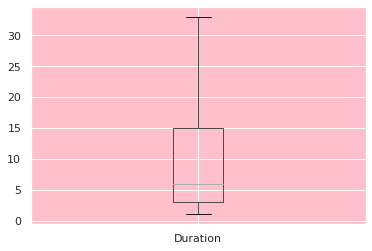

In [183]:
# your code here
# report the basic statistics of duration in 'validated' dataset
# boxplot code here
import matplotlib
#using matlob we are here mapping the important data such as mean, min, max values of the sets obtained from above progra
print(round(outFile_valid['Duration'].mean(),2),'--> MEAN TIME in secs')
print(outFile_valid['Duration'].max(),'--> MAXIMUM TIME in secs')
print(outFile_valid['Duration'].min(),'--> MINIMUM TIME in secs')
box_plot = outFile_valid.boxplot(column='Duration', showfliers=False)
box_plot.set(facecolor = 'pink' )
print('Most UFO sightings appear to be biased towards shorter timescales')

### (15pts) Part 1c: Can we do better?
Interesting. But we threw away a **lot** of data. We can do better. For this part, you will do your best to clean up the durations from your original dataset. Keep in mind some initial guidelines:

* If a duration has a range, use the average as its value. For example, if the duration is listed as “6-8 minutes”, you should consider the duration as “7 minutes”. (Again, you will need to eventually convert minutes into seconds).
* If a duration has a “<” sign, you should simply ignore the “<” sign. For example if the duration is specified as “< 1 minute”, consider the duration to be “1 minute”. You should subsequently convert “1 minute” to "60 seconds".
* If a duration has a “>” sign, you should simply ignore the “>” sign. 
* You should ignore any row with an empty duration.

You will probably have to improvise as you go along, so **make detailed notes of what decisions you are making and why**.

In [184]:
# your code here 
# clean data 
# convert cleaned durations to seconds
#using the library re to specify the repititive itemsets
import re
outFile_validImprovised = outFile.dropna()
outFile_validImprovised = outFile_validImprovised.apply(lambda temp: temp.astype(str).str.lower())
outFile_validImprovised = outFile_validImprovised[outFile_validImprovised.Duration.str.match('^[>~<]?(about)? *([0-9]([.-/][0-9])*){1,}[-/]*(([0-9](.[0-9])*){1,})? *(second|minute|mins|hour|day|week|month|year|seconds|minutes|hours|days|weeks|months|years)$')]

def time_frame(time_frame):
  time_frame = time_frame.replace('<','').replace('>','').replace('~','').replace('about','').strip()
  t_split = re.split(' |-', time_frame)
  t_split = list(filter(None, t_split))
  if len(t_split) == 3:
#splitting the time indices 
    if '\\' in t_split[0]:
      t_split1 = [temp for temp in t_split[0].split('\\') if temp != '']
      t_split[0] = str(int(t_split1[0])/int(t_split1[1]))
    elif '/' in t_split[0]:
      t_split1 = [temp for temp in t_split[0].split('/') if temp != '']
      t_split[0] = str(int(t_split1[0])/int(t_split1[1]))
      
    if '\\' in t_split[1]:
      t_split1 = [temp for temp in t_split[1].split('\\') if temp != '']
      t_split[1] = str(int(t_split[0]) + int(t_split1[0])/int(t_split1[1]))
      t_split[0] = str((int(t_split[1]) + int(t_split[0]))/2)
    elif '/' in t_split[1]:
      t_split1 = [temp for temp in t_split[1].split('/') if temp != '']
      t_split[1] = str(int(t_split[0]) + int(t_split1[0])/int(t_split1[1]))
    del t_split[1]
  if len(t_split) == 1:
    t_split = [temp for temp in re.split('(min|sec|hr|mins|secs|hrs)',t_split[0]) if temp != '']
  if '/' in t_split[0]:
      t_split1 = [temp for temp in t_split[0].split('/') if temp != '']
      t_split[0] = str(int(t_split1[0])/int(t_split1[1]))
  elif '\\' in t_split[0]:
    t_split1 = [temp for temp in t_split[0].split('\\') if temp != '']
    t_split[0] = str(int(t_split1[0])/int(t_split1[1]))
# if there are timed sightings - 0 
#converting the time to seconds scale
  if len(t_split) == 1 or ':' in time_frame:
    return 0
  if t_split[1] in 'MINUTES':
    return (float(t_split[0])*60)
  elif t_split[1] in 'HOURS':
    return (float(t_split[0])*60*60)
  elif t_split[1] in 'DAYS':
    return (float(t_split[0])*60*60*24)
  elif t_split[1] in 'WEEKS':
    return (float(t_split[0])*60*60*24*7)
  elif t_split[1] in 'MONTHS':
    return (float(t_split[0])*60*60*24*30)
  elif t_split[1] in 'YEARS':
    return (float(t_split[0])*60*60*24*365)
  return float(t_split[0])

outFile_validImprovised['Duration'] = outFile_validImprovised.apply(lambda temp: time_frame(temp['Duration']), axis=1)
outFile_validImprovised.head()

,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/14/21 22:30,dallas,tx,formation,8.0,it was loud like rocket in a v shape.,12/19/21
1,12/12/21 17:30,dallas,tx,light,10.0,a light that was fading in and out.,12/19/21
5,12/3/21 21:00,sanderson,tx,light,1.0,sighting of odd light in night sky.,12/19/21
9,12/1/21 08:00,austin,tx,changing,5.0,((hoax)) ufo on a star with men in red armore...,12/19/21
12,11/12/21 10:00,hickory creek,tx,circle,2.0,2 identical circular orange spheres traveling ...,11/15/21


In [185]:
# your code here
# total rows in original dataset
# valid rows in your cleaned dataset
print('Original dataset rows -->', outFile_actlen)
print('Valid dataset rows -->:', outFile_validImprovised.shape[0])

Original dataset rows --> 5631
Valid dataset rows -->: 3617


11.26 --> MEAN TIME in secs
120.0 --> MAXIMUM TIME in secs
1.0 --> MINIMUM TIME in secs 
Most UFO sightings appear to be biased towards shorter timescales


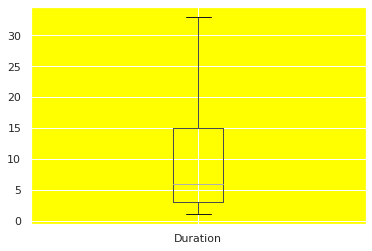

In [186]:
# your code here
# report the basic statistics of duration in your cleaned dataset
# draw a boxplot for your cleaned dataset
print(round(outFile_validImprovised['Duration'].mean(),2),'--> MEAN TIME in secs')
print(outFile_validImprovised['Duration'].max(),'--> MAXIMUM TIME in secs')
print(outFile_valid['Duration'].min(),'--> MINIMUM TIME in secs ')
box_plot = outFile_valid.boxplot(column='Duration', showfliers=False)
box_plot.set(facecolor = 'yellow' )
print('Most UFO sightings appear to be biased towards shorter timescales')

### (5pts) Part 1d: Observations and Conclusions

Based on your analysis on part 1b and 1c, what observations or conclusions can you make from the data?

*your answer here*
Even though both the distributions are identical on a whole. From the above example we can establish some crucial points such as, in  the 1st cleaning methodology most of the data got omitted whilst the second method improvised the cleaning in much more efficient way. The inclusion of data-points changed the interquartile range by moving almost 50 units downwards.

### (5pts) Part 1e: Next Steps

Now is your chance to conduct an interesting analysis on the UFO data you have collected. This is open-ended, so you may choose whatever direction you like. For example, you might want to take a look at the shape of the UFOs or perhaps the temporal aspects of the reports. 

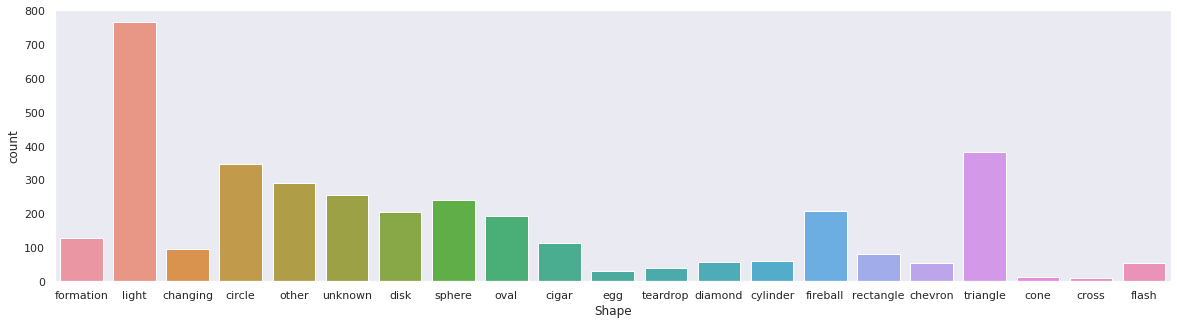


OCCURENCE OF TOP 10 SHAPES


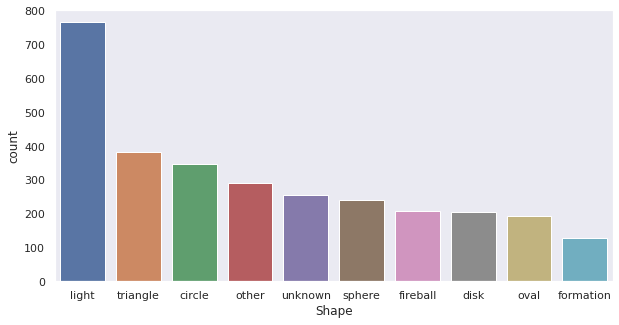

In [187]:
# your code here
#using the seaborn library for proper visualization of the data
import seaborn
import matplotlib.pyplot as plt
plt.subplots(figsize=(20,5))
seaborn.set(style="dark")
seaborn.countplot(x="Shape", data=outFile_validImprovised)
plt.show()
print()
print('OCCURENCE OF TOP 10 SHAPES')
plt.subplots(figsize=(10,5))
seaborn.countplot(x="Shape", data=outFile_validImprovised,
                  order=pd.value_counts(outFile_validImprovised['Shape']).iloc[:10].index)
plt.show()

*tell us what next steps you took, and what you discovered*

## (50 points) Part 2: Association Rules in Movie Rating Behaviors

For the second part of this homework, we're going to examine movies using our understanding of association rules, to find movies that "go together". For this part, you will implement the apriori algorithm, and apply it to a movie rating dataset. We'll use the [MovieLens](https://grouplens.org/datasets/movielens/) dataset.

First, run the next cell to load the dataset we are going to use.

In [188]:
import urllib3
import zipfile

http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip", preload_content=False)

with open("movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("movie.zip", "r")
for fileM in zFile.namelist():
  zFile.extract(fileM)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [189]:
!ls ml-latest-small/

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


In this dataset, there are four columns: `userId` is the integer ids of users, `movieId` is the integer ids of movies, `rating` is the rate of the user gives to the movie, and `timestamp` which we do not use here. Each row denotes that the user of given `userId` rated the movie of the given `movieId`. We are going to treat each user as a "basket", so you will need to collect all the movies that have been rated by a single user as a basket. 

Now, you need to implement the apriori algorithm and apply it to this dataset to find association rules of user rating behaviors where:

1. Define `rating` >= 3 is "like" (that is, only consider movie ratings of 3 or higher in your baskets; you may ignore all others)
2. `minimum_support` == 40 (out of 600 users/baskets); we may adjust this based on the discussion on Campuswire
3. `minconf` == to be determined by a discussion on Campuswire. You may try several different choices, but we will converge on a good choice for everyone for the final submission.
 
We know there are many existing implementations of apriori online (check github for some good starting points). You are welcome to read existing codebases and let that inform your approach. Do not copy-paste any existing code. We want your code to have sufficient comments to explain your steps, to show us that you really know what you are doing. Furthermore, you should add print statements to print out the intermediate steps of your method -- e.g., the size of the candidate set at each step of the method, the size of the filtered set, and any other important information you think will highlight the method. 

To help get you started, we can load the ratings with the following code snippet:

In [190]:
import pandas as pd
# read user ratings
allRatings = pd.read_csv("ml-latest-small/ratings.csv")
allRatings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### (15pts) Step 1: Implement Apriori Algorithm
In this section, you need to implement the Apriori algorithm, we will check the correctness of your code and we encourage efficient implementation and skills of pruning.

In [191]:
# your code here
import itertools
import copy
def Apriori_Algorithm(allRatings,minimum_rate, min_sup):
  candidate_sets = dict()
  high_rating = allRatings[allRatings['rating'] >= 3].drop(columns = ['rating','timestamp'])
  print(high_rating.shape[0], 'rows along with ratings >=', minimum_rate)
  user_shopCart = {x:set() for x in high_rating['userId'].unique()}
  movie_id1 = high_rating['movieId'].unique()
  for row in high_rating.itertuples():
    user_shopCart[row.userId].add(row.movieId)
  movie_count1 = {x:0 for x in movie_id1}
  for movie in movie_id1:
    for set_of_movies in user_shopCart.values():
      if movie in set_of_movies:
        movie_count1[movie] += 1
  movie_count1Tuples = {tuple([key]): value for (key, value) in movie_count1.items()}
  candidate_sets.update(movie_count1Tuples)
  movie_sets = set()

  # set_of_filtered_movies1 stores set of all movies with frequency at least min_sup
  set_of_filtered_movies1 = {key for (key,value) in movie_count1.items() if value >= min_sup}
  print('movies that have minimum support >= ', min_sup, 'are', len(set_of_filtered_movies1))
  movie_sets.update(set_of_filtered_movies1)

  # if there is a filtered_movie that the user has rated
  user_shopCart1 = {key : value for (key,value) in user_shopCart.items() if value.intersection(set_of_filtered_movies1)}
  user_shopCartTotal = copy.deepcopy(user_shopCart)
  print('no.of records in the frequent-itemset 1 are', len(user_shopCart1))
  print('******************************************************************************')
  user_shopCartPrev = user_shopCart1
  set_of_filtered_moviesPrev = set_of_filtered_movies1
  k = 2
  associated_colums = ['A', 'B', 'AB']
  ab_list = list()
  while(len(user_shopCartPrev) != 0):
    movie_id = list(itertools.combinations(list(set_of_filtered_moviesPrev),k))
    movie_count = {tuple(sorted(x)):0 for x in movie_id}
    print('number of frequent-itemset pairs:',len(movie_id))

    # For every movie combination, if the movie tuple is in the user's rating
    for movie in movie_id:
      for set_of_movies in user_shopCartPrev.values():
        if set(movie).issubset(set_of_movies):
          movie_count[tuple(sorted(movie))] += 1
    candidate_sets.update(movie_count)

    # set_of_filtered_movies pairs with frequency at least min_sup
    set_of_filtered_movies = {key for (key,value) in movie_count.items() if value >= min_sup}
    movie_sets.update(set_of_filtered_movies)
    print('movies in the frequent-itemset', k ,'with minimum support greater than', min_sup,'are', len(set_of_filtered_movies))
    user_shopCart = dict()
    for key, value in user_shopCartPrev.items():
      for movie in set_of_filtered_movies:
        if set(movie).issubset(value):
          user_shopCart[key] = value
    print('no.of records with frequent-itemset', k, 'are', len(user_shopCart))
    set_of_filtered_moviesPrev = set(itertools.chain(*set_of_filtered_movies))
    user_shopCartPrev = user_shopCart
    for ab in set_of_filtered_movies:
      ab = tuple(sorted(ab))
      for b in ab:
        b1 = set()
        b1.add(b)  
        a = tuple(set(ab) - b1)
        y = tuple(b1)
        ab_list.append([a, b, ab])
    k += 1
    print('******************************************************************************')
  dataFrame = pd.DataFrame(ab_list, columns=associated_colums)
  return dataFrame, candidate_sets, movie_sets
dataFrame, candidate_sets, movie_sets = Apriori_Algorithm(allRatings,3, 150)

81763 rows along with ratings >= 3
movies that have minimum support >=  150 are 37
no.of records in the frequent-itemset 1 are 576
******************************************************************************
number of frequent-itemset pairs: 666
movies in the frequent-itemset 2 with minimum support greater than 150 are 30
no.of records with frequent-itemset 2 are 476
******************************************************************************
number of frequent-itemset pairs: 969
movies in the frequent-itemset 3 with minimum support greater than 150 are 2
no.of records with frequent-itemset 3 are 192
******************************************************************************
number of frequent-itemset pairs: 1
movies in the frequent-itemset 4 with minimum support greater than 150 are 0
no.of records with frequent-itemset 4 are 0
******************************************************************************


In [192]:
#code for generating association rules
def get_conf(ab, a, candidate_set_count):
  return candidate_set_count[tuple(sorted(ab))]/candidate_set_count[tuple(sorted(a))]
def app_conf(min_conf, dataFrame, candidate_set_count):
  dataFrame['confidence'] = dataFrame.apply(lambda a: get_conf(a['AB'], a['A'], candidate_set_count), axis=1)
  dataFrame = dataFrame[dataFrame['confidence'] >= min_conf]
  return dataFrame
min_conf = 0.8
dataFrame = app_conf(min_conf, dataFrame, candidate_sets)
print('Associations rules generated for greater than minimum confidence of', min_conf,'-->', dataFrame.shape[0])
dataFrame

Associations rules generated for greater than minimum confidence of 0.8 --> 14


,A,B,AB,confidence
10,"(7153,)",5952,"(5952, 7153)",0.862069
11,"(5952,)",7153,"(5952, 7153)",0.862069
14,"(5952,)",4993,"(4993, 5952)",0.890805
15,"(4993,)",5952,"(4993, 5952)",0.846995
16,"(7153,)",4993,"(4993, 7153)",0.890805
17,"(4993,)",7153,"(4993, 7153)",0.846995
19,"(150,)",356,"(150, 356)",0.816216
32,"(1210,)",260,"(260, 1210)",0.870270
39,"(47,)",296,"(47, 296)",0.827225
46,"(480,)",356,"(356, 480)",0.819444


### (5pts) Step 2: Print Your Association Rules

Next you should print your final association rules in the following format:

**movie_name_1, movie_name_2, ... --> 
movie_name_k**

where the movie names can be fetched by joining the movieId with the file `movies.csv`. For example, one rule that you might find is:

**Matrix, The (1999),  Star Wars: Episode V - The Empire Strikes Back (1980),  Star Wars: Episode IV - A New Hope (1977),  -> 
Star Wars: Episode VI - Return of the Jedi (1983)**

In [193]:
# your code here
# Read the movie dataset for printing the movies rather than movieIds
movie_title = pd.read_csv('ml-latest-small/movies.csv')

# listing out the movie names from the dataFrame
def movie_name(candidate_sets, movie_title):
    return movie_title.loc[movie_title['movieId'] == candidate_sets]['title'].values[0]

# printing the movie names with corresponding associative rules
def get_associative_rules(dataFrame, movie_title):
  k = 1
  for row in dataFrame.itertuples():
    left = [movie_name(m, movie_title) for m in row.A]
    leftStr = '| '.join(left)
    right = movie_name(row.B, movie_title)
    print(k,':',leftStr, '---|>', right)
    k=k+1
association_rules = get_associative_rules(dataFrame, movie_title)
association_rules

1 : Lord of the Rings: The Return of the King, The (2003) ---|> Lord of the Rings: The Two Towers, The (2002)
2 : Lord of the Rings: The Two Towers, The (2002) ---|> Lord of the Rings: The Return of the King, The (2003)
3 : Lord of the Rings: The Two Towers, The (2002) ---|> Lord of the Rings: The Fellowship of the Ring, The (2001)
4 : Lord of the Rings: The Fellowship of the Ring, The (2001) ---|> Lord of the Rings: The Two Towers, The (2002)
5 : Lord of the Rings: The Return of the King, The (2003) ---|> Lord of the Rings: The Fellowship of the Ring, The (2001)
6 : Lord of the Rings: The Fellowship of the Ring, The (2001) ---|> Lord of the Rings: The Return of the King, The (2003)
7 : Apollo 13 (1995) ---|> Forrest Gump (1994)
8 : Star Wars: Episode VI - Return of the Jedi (1983) ---|> Star Wars: Episode IV - A New Hope (1977)
9 : Seven (a.k.a. Se7en) (1995) ---|> Pulp Fiction (1994)
10 : Jurassic Park (1993) ---|> Forrest Gump (1994)
11 : Star Wars: Episode VI - Return of the Jedi (

### (15pts) Step 3: Implement Random Sampling

We discussed in class a method to randomly sample baskets to avoid the overhead of reading the entire set of baskets (which in practice, could amount to billions of baskets). For this part, you should implement such a random sampling approach that takes a special parameter **alpha** that controls the size of the sample: e.g., alpha = 0.10 means to sample 10% of the baskets (our users, in this case). 

Vary **alpha** and report the number of frequent itemsets you find and how this compares to the number of frequent itemsets in the entire dataset. What do you discover?


In [194]:
#  your code here

for k in range(10):
  alpha = (k+1)/10
  ar_sample = allRatings.sample(frac = alpha)
  dataFrame_sample, set_freq_for_moviesample, movie_sets_sample = Apriori_Algorithm(ar_sample,3, 150)
  print('-----------------------------------------------------------------')
  print('Alpha: ', str(alpha*100) + '%', '|size of the sample with frequent-itemset:', len(set_freq_for_moviesample))
  print('-----------------------------------------------------------------')

8187 rows along with ratings >= 3
movies that have minimum support >=  150 are 0
no.of records in the frequent-itemset 1 are 0
******************************************************************************
-----------------------------------------------------------------
Alpha:  10.0% |size of the sample with frequent-itemset: 3031
-----------------------------------------------------------------
16355 rows along with ratings >= 3
movies that have minimum support >=  150 are 0
no.of records in the frequent-itemset 1 are 0
******************************************************************************
-----------------------------------------------------------------
Alpha:  20.0% |size of the sample with frequent-itemset: 4303
-----------------------------------------------------------------
24553 rows along with ratings >= 3
movies that have minimum support >=  150 are 0
no.of records in the frequent-itemset 1 are 0
***********************************************************************

*Observations:*

As the alpha value increases from 10% to 1(all recorda) we see the frequent itemsets increase too.

We start getting frequent itemsets after alpha = 50% and get good results at alpha = 0.8

### (10pts) Step 4: Check for False Positives

Next you should verify that the candidate pairs you discover by random sampling are truly frequent by comparing to the itemsets you discover over the entire dataset. 

For this part, consider another parameter **minimum_support_sample** that relaxes the minimum support threshold. For example if we want minimum_support = 1/100 for whole dataset, then try minimum_support_sample = 1/125 for the sample. This will help catch truly frequent itemsets.

Vary **minimum_support_sample** and report the number of frequent itemsets you find and the number of false positives you find. What do you discover?


In [195]:
# your code here
import time
alphas = [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 1]
minSupSamples = [100,110, 120, 130, 140, 150,150]
fpDfList = []

for i in range(len(alphas)):
  arSample = allRatings.sample(frac = alphas[i])
  sTime = time.time()
  dfSample, movieSetFreqsSample, movie_sets_sample = Apriori_Algorithm(arSample, 3, minSupSamples[i])
  eTime = time.time()
  print('________________________________________')
  print('Alpha:', alphas[i]*100, 'minSupSample:', minSupSamples[i], 'False_Positives:', len(movie_sets_sample-movie_sets))
  print('Size of frequent itemset Sample:', len(movie_sets_sample),'| Size of frequent itemset:' ,len(movie_sets))
  print('________________________________________')


49020 rows along with ratings >= 3
movies that have minimum support >=  100 are 31
no.of records in the frequent-itemset 1 are 562
******************************************************************************
number of frequent-itemset pairs: 465
movies in the frequent-itemset 2 with minimum support greater than 100 are 0
no.of records with frequent-itemset 2 are 0
******************************************************************************
________________________________________
Alpha: 60.0 minSupSample: 100 False_Positives: 0
Size of frequent itemset Sample: 31 | Size of frequent itemset: 69
________________________________________
49154 rows along with ratings >= 3
movies that have minimum support >=  110 are 21
no.of records in the frequent-itemset 1 are 525
******************************************************************************
number of frequent-itemset pairs: 210
movies in the frequent-itemset 2 with minimum support greater than 110 are 0
no.of records with frequent-i

*Alpha of 60% is giving good values with min support of 100*

### (5pts) Step 5: Extensions and Next Steps

So far, we have been working with a fairly small dataset. For this last question, try your sampling-based approach on the much larger: **Movies 10M** dataset: https://files.grouplens.org/datasets/movielens/ml-10m.zip

First, we need to load this larger dataset:

In [196]:
import urllib3
import zipfile

http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-10m.zip", preload_content=False)

with open("movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("movie.zip", "r")
for fileM in zFile.namelist():
  zFile.extract(fileM)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [197]:
! ls ml-10M100K/

allbut.pl  movies.dat  ratings.dat  README.html  split_ratings.sh  tags.dat


In [198]:
import pandas as pd
# read user ratings
allRatings = pd.read_csv("ml-10M100K/ratings.dat",sep='::', names=["userId", "movieId", "rating", "timestamp"], engine='python')
allRatings

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
...,...,...,...,...
10000049,71567,2107,1.0,912580553
10000050,71567,2126,2.0,912649143
10000051,71567,2294,5.0,912577968
10000052,71567,2338,2.0,912578016


Now you can begin your sampling over this larger dataset.

In [199]:
# your code here
# your code here
import time
alpha = 0.65
ar_sample = allRatings.sample(frac = alpha)
minsup_sample = 0.001 * allRatings.shape[0]
sTime = time.time()
dfSample, set_freq_moviesample, movie_set_sample = Apriori_Algorithm(ar_sample, 3, minsup_sample)
eTIme = time.time()
print('________________________________________')
print('Alpha: ', str(alpha*100) + '%', '|size of the sample with frequent-itemset:', len(set_freq_for_moviesample))
print('size of the sample with frequent-itemset:', len(movie_set_sample))
print('________________________________________')

5358258 rows along with ratings >= 3
movies that have minimum support >=  10000.054 are 46
no.of records in the frequent-itemset 1 are 65498
******************************************************************************
number of frequent-itemset pairs: 1035
movies in the frequent-itemset 2 with minimum support greater than 10000.054 are 0
no.of records with frequent-itemset 2 are 0
******************************************************************************
________________________________________
Alpha:  65.0% |size of the sample with frequent-itemset: 10088
size of the sample with frequent-itemset: 46
________________________________________


As the dataset is huge more number of alpha and support values have to be checked against using different percentages of random sampling.

*worked with Rajesh Satpathy, referred to the below link
https://www.kite.com/python/examples/4420/beautifulsoup-parse-an-html-table-and-write-to-a-csv*